In [1]:
import os
import re
import json
import glob
from collections import defaultdict
from functools import partial

import numpy as np 
import pandas as pd 
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt 

import nltk
import string

In [2]:
train_df = pd.read_csv("dataset/train.csv")
sample_sub = pd.read_csv('dataset/sample_submission.csv')
train_fp = "dataset/train/"
test_fp = "dataset/test/"

In [3]:
train_df.head(5)

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


In [5]:
def read_append_return(filename, train_files_path=train_fp, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [6]:
%%time
tqdm.pandas()   #tqdm is used to show any code running with a progress bar. 
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

/home/ry/.local/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 19661/19661 [00:04<00:00, 4023.26it/s]CPU times: user 4.14 s, sys: 772 ms, total: 4.91 s
Wall time: 4.89 s



In [7]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = re.sub(' +', ' ', str(text).lower()).strip()
    #text = ''.join([k for k in text if k not in string.punctuation])
    #text = re.sub('[^A-Za-z0-9\(\)]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
     
    return text

In [8]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

100%|██████████| 19661/19661 [00:55<00:00, 356.56it/s]CPU times: user 53.1 s, sys: 2.41 s, total: 55.5 s
Wall time: 55.1 s



In [9]:
train_df.head(5)

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth, ..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1. accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [10]:
from model import search_sentences
from custom_classes import PosMap

In [11]:
i = 0
limit = 100
p = 5
q = 4
pre_tf = PosMap(p)
post_tf = PosMap(q)

for row in train_df.iterrows():
    label = row[1]["cleaned_label"]
    text = row[1]["text"].lower()
    act, deact = search_sentences(label, text, pre=p, post=q)

    for j in range(len(act)):
        pre_words = act[j].split()[::-1]
        post_words = deact[j].split()
        for k in range(min([len(pre_words), p])):
            try:
                word = pre_words[k]
                pre_tf[k][word] += 1
            except IndexError:
                print(act[j])
        
        for k in range(min([len(post_words), q])):
            try:
                word = post_words[k]
                post_tf[k][word] += 1
            except IndexError:
                print(deact[j])

    i += 1
    #if i >= limit: break

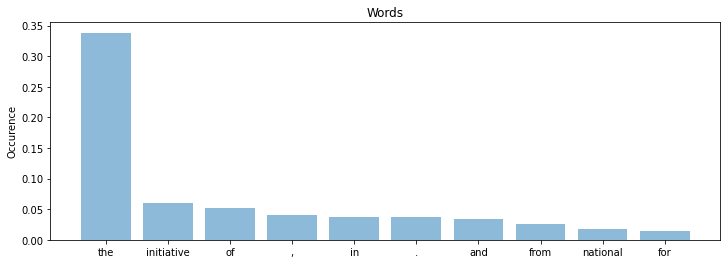

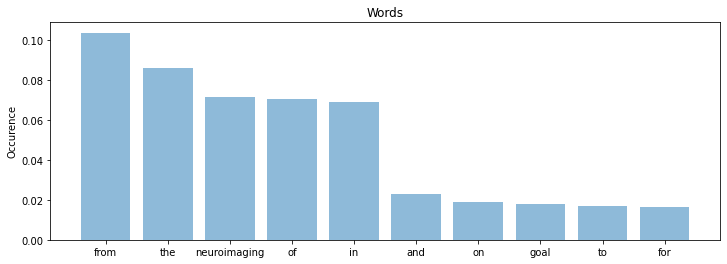

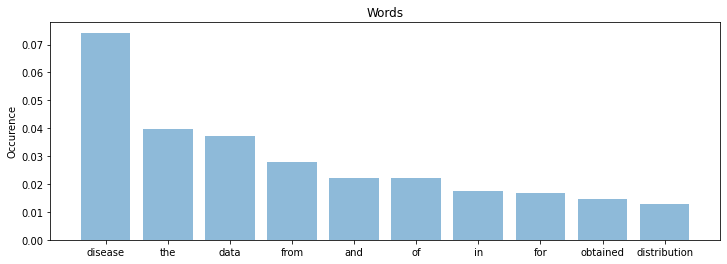

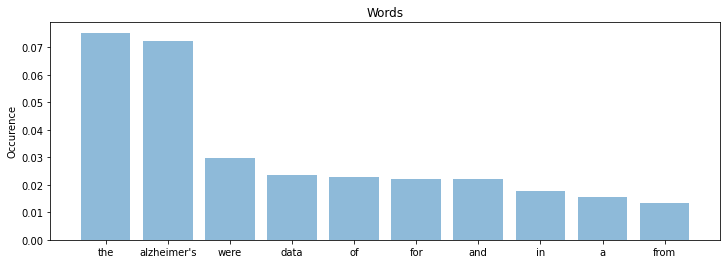

In [12]:
pre_tf.plot(idx=0) # the first closest pre words
pre_tf.plot(idx=1) # the second closest pre words
pre_tf.plot(idx=2) # the third
pre_tf.plot(idx=3)


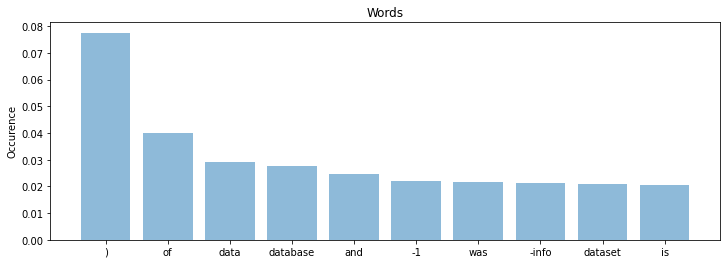

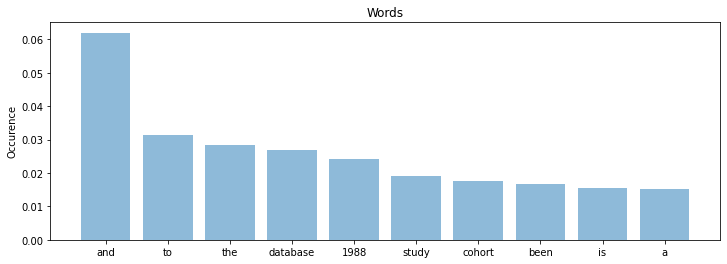

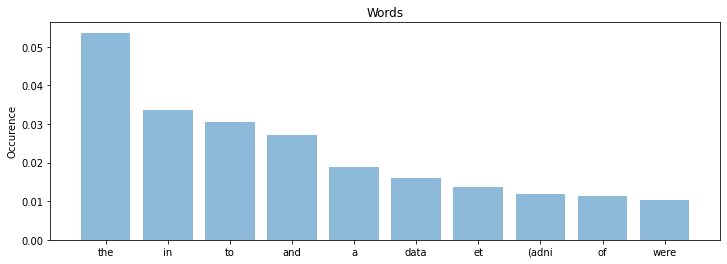

In [13]:
post_tf.plot(idx=0)
post_tf.plot(idx=1)
post_tf.plot(idx=2)

In [14]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth, ..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1. accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [15]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_fp))

/home/ry/.local/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 4/4 [00:00<00:00, 1550.57it/s]CPU times: user 6.13 ms, sys: 32 µs, total: 6.16 ms
Wall time: 5.16 ms



In [16]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9\(\)]+', ' ', str(txt).lower()).strip()

In [17]:
# STRING MATCHING BLOCK
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:   # for each label in the known set
        if known_label in sample_text.lower():   # find the label in text TODO: this only does exact matches, so maybe add fuzzy matches?
            cleaned_labels.append(clean_text(known_label)) # if found, then append to the list for further formatting
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

4it [00:00, 10.78it/s]


In [18]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['PredictionString'] = lables_list

In [19]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
submission.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative ad...
1,2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data|trends in internation...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,sea lake and overland surges from hurricanes|s...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [20]:
submission.to_csv('submission.csv', index=False)